# Utilities

In [11]:
import os, sys
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath('.')))
sys.path.append(parent_dir)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

class Analyzer:
    
    def __init__(self, network):
        self.network = network
        
    def get_degree_distribution(self):
        "Returns the plot of the degree distribution with a log-log scale"
        
        N = self.network.number_of_nodes()
        degrees = [self.network.in_degree(n) for n in self.network.nodes()] if self.network.is_directed() else [self.network.degree(n) for n in self.network.nodes()]
        
        N_k = {}
        for k in degrees:
            if k not in N_k:
                N_k[k] = 1
            else:
                N_k[k] += 1
                
        p_k = {}
        for k in N_k:
            p_k[k] = N_k[k] / N
        
        # Plotting in log-log scale
        plt.figure(figsize=(8, 6))
        plt.loglog(list(p_k.keys()), list(p_k.values()), marker='o', linestyle='None', color='b')
        plt.title('Log-log Degree Distribution')
        plt.xlabel('Degree')
        plt.ylabel('Frequency')
        plt.grid(True)

        return plt

# Random Graphs

In [ ]:
from networks_gen import randomG
import random

n = 25000

# take p randomly between 1/24999 and 1
p = random.uniform(1/(n-1), 0.01)

g1 = randomG(n, p)
analyzer_g1 = Analyzer(g1)
plt = analyzer_g1.get_degree_distribution()
plt.show()

In [ ]:
print(len(g1.edges()))
print(len(g1.nodes()))

In [ ]:
# save the graph
print(p)

In [ ]:
# save the graph
print(stream_diam(g1))

# Configuration model

In [ ]:
import networkx as nx
import numpy as np

degree_distribution = [d for _, d in G.degree()]

min = np.min(degree_distribution)
max = np.max(degree_distribution)

# normalize the degree distribution beteen 0 and max - min
normalized_degree_distribution = [d - min for d in degree_distribution]

if np.sum(normalized_degree_distribution) % 2 != 0:
    normalized_degree_distribution[0] += 1

# Generate the small graph
small_graph = nx.configuration_model(normalized_degree_distribution[:3000])

# Compute the degree distribution of the small graph
analyzer_g2 = Analyzer(small_graph)
plt = analyzer_g2.get_degree_distribution()
plt.show()

In [ ]:
nx.draw_networkx(small_graph, with_labels=False, linewidths=0.01, node_size=1, width=0.1)
plt.show()

# Preferential Attachment

In [ ]:
from networks_gen import preferentialG
import random

# generate a preferential graph for n = 25000 and different values of p (between 0 excluded and 1 included) and plot the degree distribution for each graph
n = 25000

ps = [0.01, 0.1, 0.5, 0.7, 1]

# take p randomly between 1/24999 and 1
for p in ps:
    g2 = preferentialG(n, p)
    analyzer_g2 = Analyzer(g2)
    print(len(g2.edges()))
    plt = analyzer_g2.get_degree_distribution()
    plt.show()

# Generalized Watts-Strogatz

In [ ]:
import networkx as nx
import numpy as np
from networks_gen import GenWS2DG

# degree_distribution = [d for _, d in G.degree()]

# min = np.min(degree_distribution)
# max = np.max(degree_distribution)

# # normalize the degree distribution beteen 0 and max - min
# normalized_degree_distribution = [d - min for d in degree_distribution]

# normalized_degree_distribution = normalized_degree_distribution[:3000]

# if np.sum(normalized_degree_distribution) % 2 != 0:
#     normalized_degree_distribution[-1] += 1

# Generate the small graph
small_graph = GenWS2DG(2500, 1, 1000, 1)

# Compute the degree distribution of the small graph
analyzer_g2 = Analyzer(small_graph)
plt = analyzer_g2.get_degree_distribution()
plt.show()

# Affiliation Networks

In [2]:
import networkx as nx

G = nx.read_edgelist('net_2', nodetype=int)
print(len(G.nodes()))
print(len(G.edges()))

25000
23000065


In [76]:
avg_degree_G = int(sum(dict(G.degree()).values()) / len(G))
print(avg_degree_G)

1840


## Communities

In [4]:
import networkx as nx

def operlapping_louvain(G, n_iter = 2):
    
    # STEP 1. execute the louvain algorithm n_iter times and record the results
    results = []
    for i in range(n_iter):
        results.append([])
        communities = nx.community.louvain_communities(G)   
        for community in communities:
            results[i].append(community)
            
    mean_len = sum([len(row) for row in results]) / len(results)

    # STEP 2. build the belonging matrix with N rows (number of nodes) and C columns (number of communities)
    n_nodes = len(G.nodes())
    
    # initialize the belonging matrix, each node ia a community
    belonging_matrix = [[0 for _ in range(n_nodes)] for _ in range(n_nodes)]

    # fill the belonging matrix
    for row in results:
        for i, community in enumerate(row):
            for node in community:
                for neighbor in G.neighbors(node):
                    if neighbor in community:
                        belonging_matrix[node][i] += 1
                          
    # normalize the belonging matrix in range [0,1] to compute the belonging coefficient of each node to each community
    # take the maximum coefficient of the whole matrix
    max_coefficient = max([max(row) for row in belonging_matrix])
    for row in belonging_matrix:
        for i in range(len(row)):
            row[i] /= max_coefficient
            
    # take non null elements of the belonging matrix
    non_null_elements = []
    for row in belonging_matrix:
        for element in row:
            if element > 0:
                non_null_elements.append(element)
    
    # compute lambda_
    lambda_ = sum(non_null_elements)/len(non_null_elements)
    print("lambda:", lambda_)
    
    # if the coefficient is greater than lambda_ then the node belongs to the community
    communities = {i: set() for i in range(n_nodes)}
    i = 1
    for node in belonging_matrix:
        for j in range(n_nodes):
            if node[j] > lambda_:
                communities[j].add(i)
        i += 1
        
    # remove empty communities
    for community in list(communities.keys()):
        if len(communities[community]) == 0:
            communities.pop(community)
            
    print("Number of communities:", len(communities))

    return communities, belonging_matrix, lambda_, mean_len

In [5]:
from networks_gen import affiliationG

communities, belonging_matrix, lambda_, mean_len = operlapping_louvain(G, 50)
print("Mean length:", mean_len)
# save the belonging matrix in a file
belonging_matrix_file = open("belonging_matrix.txt", "w")
for row in belonging_matrix:
    belonging_matrix_file.write(str(row) + "\n")
belonging_matrix_file.close()

lambda: 0.27731050322220085
Number of communities: 4
Mean length: 4.0


In [9]:
for community in communities:
    print(community, len(communities[community]))

0 14170
1 14171
2 11728
3 3527


In [8]:
# c = mean number of non null elements above lambda_ in the belonging matrix per row
tot = []
for row in belonging_matrix:
    c = 0
    for element in row:
        if element > lambda_:
            c += 1
    tot.append(c)
    
c = max(tot)
print("c:", c)

c: 4


In [7]:
# m = mean number of non null elements in the belonging matrix per column
tot = []
for i in range(len(belonging_matrix[0])):
    c = 0
    for j in range(len(belonging_matrix)):
        if belonging_matrix[j][i] > 0:
            c += 1
    tot.append(c)
    
m = sum(tot)/len(tot)
print("m:", m)

m: 4.53168


## Affiliation probability and strong ties probability

In [3]:
from networks_gen import affiliationG

def generate_affiliation_network(n, m, c, s, p, q):
    g = affiliationG(n, m, q, c, p, s)
    return g

def evaluate_network(G):
    avg_degree = int(sum(dict(G.degree()).values()) / len(G))
    return abs(avg_degree_G - avg_degree)

n = 25000
m = int(m)
c = int(c)
s = 1
p = 0.01
q = 0.1

best_p = 0.01
best_q = 0.1
best_score = float('inf')
prev_score = float('inf')

max_iterations = 10
threshold = 0.01
early_stopping = 2

while p < 0.1:
    
    q = 0.1  
    
    early_stopping = 2
    prev_score = float('inf')
    
    while q < 1:

        network = generate_affiliation_network(n, m, c, s, p, q)
        score = evaluate_network(network)
        print(f"p: {p}, q: {q}, Diff: {score}")
        
        if score < threshold:  
            break
        
        if score < best_score:
            best_score = score
            best_p = p
            best_q = q
        else:
            if prev_score <= score:
                early_stopping -= 1
            else:
                early_stopping = 5
            prev_score = score
            if early_stopping == 0:
                break
            
        q += 0.1
        
    p += 0.01
    
    if score < threshold:
        break

print(f"Best p: {best_p}, Best q: {best_q}, Best Avg Degree: {best_score}")


p: 0.01, q: 0.1, Diff: 1718
p: 0.01, q: 0.2, Diff: 1713
p: 0.01, q: 0.30000000000000004, Diff: 1707
p: 0.01, q: 0.4, Diff: 1700
p: 0.01, q: 0.5, Diff: 1694
p: 0.01, q: 0.6, Diff: 1676
p: 0.01, q: 0.7, Diff: 1654
p: 0.01, q: 0.7999999999999999, Diff: 1625
p: 0.01, q: 0.8999999999999999, Diff: 1550
p: 0.01, q: 0.9999999999999999, Diff: 1341
p: 0.02, q: 0.1, Diff: 1597
p: 0.02, q: 0.2, Diff: 1588
p: 0.02, q: 0.30000000000000004, Diff: 1575
p: 0.02, q: 0.4, Diff: 1563
p: 0.02, q: 0.5, Diff: 1545
p: 0.02, q: 0.6, Diff: 1515
p: 0.02, q: 0.7, Diff: 1489
p: 0.02, q: 0.7999999999999999, Diff: 1401
p: 0.02, q: 0.8999999999999999, Diff: 1338
p: 0.02, q: 0.9999999999999999, Diff: 849
p: 0.03, q: 0.1, Diff: 1474
p: 0.03, q: 0.2, Diff: 1462
p: 0.03, q: 0.30000000000000004, Diff: 1443
p: 0.03, q: 0.4, Diff: 1419
p: 0.03, q: 0.5, Diff: 1397
p: 0.03, q: 0.6, Diff: 1351
p: 0.03, q: 0.7, Diff: 1347
p: 0.03, q: 0.7999999999999999, Diff: 1299
p: 0.03, q: 0.8999999999999999, Diff: 1305
p: 0.03, q: 0.9999999

In [20]:
print(f"n: {n}, m: {m}, c: {c}, s: {s}, p: {best_p}, q: {best_q}")
best_q = 0.8
best_p = 0.09

n: 25000, m: 4, c: 2, s: 1, p: 0.08, q: 0.7999999999999999


In [36]:
G2 = affiliationG(n, m, best_q, c, best_p, s)

11319654


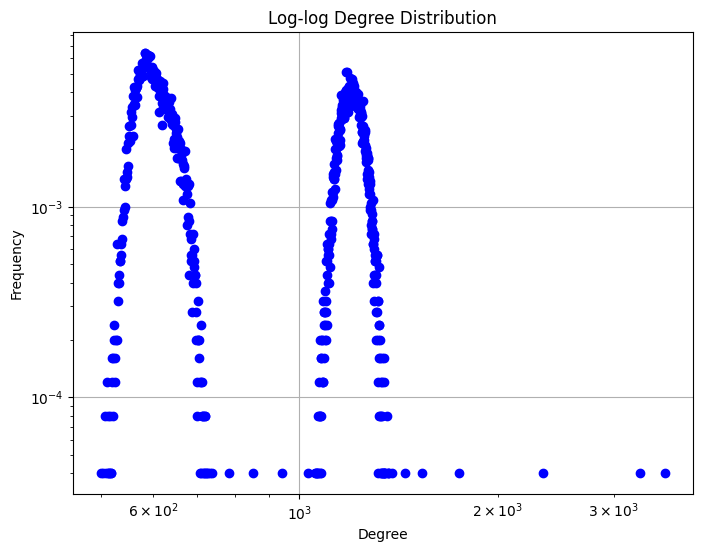

In [16]:
G2 = affiliationG(25000, 5, 0.4, 2, 0.06, 1)
print(len(G2.edges()))
analyzer_g2 = Analyzer(G2)
plt = analyzer_g2.get_degree_distribution()
plt.show()